In [1]:
import pandas as pd  # for requirements: install fastparquet as well
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import folium
from scipy.spatial import Voronoi
from math import floor, dist  # not needed in requirements

# FUNCTIONS

In [8]:
def assign_georank(enb_df, src_id, precision=1000):
    cells = np.array(enb_df[['LAT','LON']])
    centroid = np.array(enb_df[['LAT','LON']].loc[enb_df['LocInfo']==src_id]) 
    distances = np.linalg.norm(cells-centroid, axis=1) * precision   # normalized distances to centroid, between 0 and 100
    enb_df['Georank'] = [floor(d) for d in distances] 
    return enb_df

In [4]:
def compute_distance(data):
    dist_ser = pd.Series()
    for idx,row in data.iterrows():
        dist_ser[idx] = max(0.1, dist((row.srcLAT,row.srcLON), (row.dstLAT,row.dstLON))*10000)
    data['Distance'] = dist_ser
    return data

def join_ranks(data, enb_df):
    data = data.join(enb_df[['LocInfo','Georank']].set_index('LocInfo'), on='srcLocInfo')
    data.rename(columns={'Georank':'srcRank'}, inplace=True)
    data = data.join(enb_df[['LocInfo','Georank']].set_index('LocInfo'), on='dstLocInfo')
    data.rename(columns={'Georank':'dstRank'}, inplace=True)
    return data


def compute_weight(data, method='inverse', absolute=False, enb_df=None):
    if method == 'inverse':
        data['Weight'] = 1/(data['nbHO15'])  
        
    elif method == 'prop':
        ho_max, ho_min = data['nbHO15'].max(), data['nbHO15'].min()
        data['Weight'] = (ho_max - data.nbHO15)/(ho_max-ho_min)
        
    elif method == 'distance':
        if 'Distance' not in data.columns:
            data = compute_distance(data)
        data['Weight'] = data.Distance / data.nbHO15
        
    elif method == 'rank':
        if 'srcRank' not in data.columns:
            data = join_ranks(data, enb_df)
        ser = pd.Series()
        if absolute:
            for idx,row in data.iterrows():
                ser[idx] = max(1, abs(row.srcRank - row.dstRank)) / row.nbHO15
        else:
            for idx,row in data.iterrows():   
                ser[idx] = max(1, row.srcRank - row.dstRank +1) / row.nbHO15
        data['Weight'] = ser
        
    elif method == 'rank-dist':
        if 'srcRank' not in data.columns:
            data = join_ranks(data, enb_df)
        if 'Distance' not in data.columns:
            data = compute_distance(data)
        ser = pd.Series()
        if absolute:
            for idx,row in data.iterrows():
                ser[idx] = max(1, abs(row.srcRank - row.dstRank)) / row.nbHO15
        else:
            for idx,row in data.iterrows():
                ser[idx] = max(1, row.srcRank - row.dstRank +1) / row.nbHO15
        data['Weight'] = ser * data.Distance
        
    elif method == 'log':
        ho_max = data['nbHO15'].max()
        data['Weight'] = np.log(ho_max) - np.log(data.nbHO15)
        
    else:
        raise ValueError('Invalid method. Choose between inverse, prop, distance, rank, rank-dist, or log.')
    return data

In [5]:
def compute_path_ho(data, path):
    path_ho = 0
    for i in range(len(path)-1):
        arc_ho = data.loc[(data['srcLocInfo']==path[i]) & (data['dstLocInfo']==path[i+1])]['nbHO15'].iloc[0]
        arc_weight = data.loc[(data['srcLocInfo']==path[i]) & (data['dstLocInfo']==path[i+1])]['Weight'].iloc[0]
        #print('Number of handovers between', path[i], 'and', path[i+1],': ', arc_ho, '\tWeight: ', arc_weight)
        path_ho += arc_ho
    return int(path_ho)

def update_graph(graph, path, method='half'):
    if method == 'half':
        for i in range(len(path)-1):
            src, dst = path[i], path[i+1]
            weight = graph[src][dst]['Weight']
            graph[src][dst]['Weight'] = weight*2
            #print('Previous weight:', weight, '\tNew weight:', graph[src][dst]['Weight']) 
    else:
        raise ValueError('Invalid method. Choose between half or min.')
    return graph

In [6]:
def create_map():
    map = folium.Map([45.73303, 4.82297], tiles="OpenStreetMap", zoom_start=13)
    print('Creating base station map...')
    return map

def add_stations(map, df, name='4G stations'):
    print('Adding '+name+' layer')
    fg = folium.FeatureGroup(name=name) # Name as it will appear in Layer control
    enb_ids = df.srcLocInfo.unique()
    for id in enb_ids:
        enb_data = df.loc[df['srcLocInfo']==id]
        fg.add_child(folium.Marker(
            location=[enb_data['srcLAT'].iloc[-1], enb_data['srcLON'].iloc[-1]],
            popup=enb_data['srcLocInfo'].iloc[-1],
        ))
    map.add_child(fg)
    
def add_stations_by_centrality(map, df, name='4G stations'):
    print('Adding '+name+' layer...')
    fg = folium.FeatureGroup(name=name) # Name as it will appear in Layer control
    enb_color = {0:'blue', 0.007:'green', 0.026:'yellow', 0.05:'orange', 0.5:'red'}
    for idx,row in df.iterrows():
        ec = [v for k,v in enb_color.items() if row['BC'] <= k]
        fg.add_child(folium.CircleMarker(
            location=[row['LAT'], row['LON']],
            popup=row['LocInfo'],
            tooltip='Centrality: '+str(row['BC']),
            color='black',
            weight=1,
            fill=True,
            fill_color=ec[0],
            fill_opacity=0.9,
            radius=10
        ))
    map.add_child(fg)
    
def close_map(map, filename):
    folium.LayerControl().add_to(map)
    map.save('maps\\'+filename)
    print('Closing', filename, 'map.')
    
def add_voronoi(map, points):
    print('Adding Voronoi layer')
    vor = Voronoi(list(zip(points['LAT'].tolist(), points['LON'].tolist())))  # Careful with the inversion!!  
    fg = folium.FeatureGroup(name='Voronoi cells', show=True)
    for enb, reg_idx in enumerate(vor.point_region):
        region = vor.regions[reg_idx]
        if -1 not in region and region != []:
            region_coords = []
            for vertex in region:
                region_coords.append(vor.vertices[vertex])
            fg.add_child(folium.Polygon(
                region_coords,
                color="black",
                weight=1,
                fill_color="darkgray",
                fill_opacity=0.2,
                fill=True,
            ))
    map.add_child(fg)
    
    
def add_flows(map, data, name='4G Handovers', min_weight=900):
    print('Adding Flow layer', name)
    fg = folium.FeatureGroup(name=name)
    flow_weight = {100000:2, 200000:4, 300000:6, 400000:8, 500000:10}
    flow_color = {2:'blue', 4:'green', 6:'yellow', 8:'orange', 10:'red'}
    for idx, row in data.iterrows():
        if row['nbHO15'] >= min_weight:
            fw = [v for k,v in flow_weight.items() if row['nbHO15'] <= k]
            fg.add_child(folium.PolyLine(
                [(row['srcLAT'], row['srcLON']), (row['dstLAT'], row['dstLON'])],
                color = flow_color[fw[0]],
                weight = fw[0],
                opacity = 0.8,
                tooltip = 'Weight: '+str(row['nbHO15'])
            ))
    map.add_child(fg)
    
    
def add_path(map, data, path_list, name='Path', color='#AA0000', voronoi=True, enb_data=None):
    print('Adding Path layer', name)
    fg = folium.FeatureGroup(name=name)
    for i in range(1, len(path_list)):
        flow = data.loc[(data['srcLocInfo']==path_list[i-1]) & (data['dstLocInfo']==path_list[i])]
        fg.add_child(folium.PolyLine(
            locations=[[flow['srcLAT'].iloc[0], flow['srcLON'].iloc[0]], [flow['dstLAT'].iloc[0], flow['dstLON'].iloc[0]]],
            color = color,
            opacity = 0.8,
            weight = 5,
            tooltip = 'nbHO: '+str(flow['nbHO15'].iloc[0])+'\nWeight: '+str(flow['Weight'].iloc[0])
        ))

    if voronoi:
        vor = Voronoi(list(zip(enb_data['LAT'].tolist(), enb_data['LON'].tolist())))  # Careful with the inversion!!  
        for enb_idx, reg_idx in enumerate(vor.point_region):
            region = vor.regions[reg_idx]
            cell_locinfo = enb_data.LocInfo.iloc[enb_idx]
            if -1 not in region and region != []:
                region_coords = []
                if cell_locinfo in path_list:
                    for vertex in region:
                        region_coords.append(vor.vertices[vertex])
                    fg.add_child(folium.Polygon(
                        region_coords,
                        color = color,
                        weight=1,
                        fill_color = color,
                        fill_opacity=0.3,
                        fill=True,
                    ))
    map.add_child(fg)
    

def add_gt_path(map, data, name='Path', color='#AA0000'):
    print('Adding Path layer', name)
    fg = folium.FeatureGroup(name=name)
    fg.add_child(folium.PolyLine(
        locations=zip(data['LAT'].tolist(), data['LON'].tolist()),
        color = color,
        opacity = 0.8,
        weight = 5
    ))
    map.add_child(fg)


def add_voronoi_path(map, enb_data, cells_data, name='Cells path', color='green'):
    vor = Voronoi(list(zip(enb_data['LAT'].tolist(), enb_data['LON'].tolist())))  # Careful with the inversion!!  
    fg = folium.FeatureGroup(name=name, show=True)
    for enb_idx, reg_idx in enumerate(vor.point_region):
        region = vor.regions[reg_idx]
        cell_locinfo = enb_data.LocInfo.iloc[enb_idx]
        if -1 not in region and region != []:
            region_coords = []
            if type(cells_data) == list:
                if cell_locinfo in cells_data:
                    for vertex in region:
                        region_coords.append(vor.vertices[vertex])
                    fg.add_child(folium.Polygon(
                        region_coords,
                        color = color,
                        weight=1,
                        fill_color = color,
                        fill_opacity=0.3,
                        fill=True,
                    ))
            else:
                if cell_locinfo in cells_data['LocInfo'].values:
                    for vertex in region:
                        region_coords.append(vor.vertices[vertex])
                    fg.add_child(folium.Polygon(
                        region_coords,
                        color = color,
                        weight=1,
                        fill_color = color,
                        fill_opacity=0.3,
                        fill=True,
                    ))
    map.add_child(fg)

# GLOBAL VARIABLES

In [7]:
ENB_SRC = '8102f8100000ba53' 
ENB_DST = '8102f8100000a0bc'

In [13]:
METHOD = 'rank-dist'
ABS = True
NB_PATHS = 3

# DAYTIME ANALYSIS
## 1. Import data 

### Handover and EnB data

In [9]:
agg_df_day = pd.read_parquet('..\\Processed_data\\HO_AGG_16-22_DAYTIME_4G_coords_reduced.snappy.parquet', engine='fastparquet')
ho_df_day = agg_df_day.loc[agg_df_day.srcLocInfo != agg_df_day.dstLocInfo]
ho_df_day

,srcLocInfo,dstLocInfo,nbHO15,srcTechno,srcLON,srcLAT,dstTechno,dstLON,dstLAT
index,,,,,,,,,
3190,8102f8100000994e,8102f81000009952,174,4G,4.818062,45.762236,4G,4.827545,45.752980
3191,8102f8100000994e,8102f81000009957,3879,4G,4.818062,45.762236,4G,4.826112,45.774444
3192,8102f8100000994e,8102f81000009958,1163,4G,4.818062,45.762236,4G,4.835282,45.761386
3193,8102f8100000994e,8102f8100000995b,17,4G,4.818062,45.762236,4G,4.858331,45.753607
3195,8102f8100000994e,8102f81000009963,553,4G,4.818062,45.762236,4G,4.830520,45.753373
...,...,...,...,...,...,...,...,...,...
20101,8102f8100000bad0,8102f81000009b28,64321,4G,4.820179,45.775520,4G,4.819723,45.771390
20102,8102f8100000bad0,8102f8100000a01d,5526,4G,4.820179,45.775520,4G,4.789162,45.763888
20103,8102f8100000bad0,8102f8100000a104,15,4G,4.820179,45.775520,4G,4.863723,45.755097


In [10]:
PATH_TOPO = '..\\..\\Data_Handover\\TOPO\\Lyon\\part-00000-2f038a97-7faf-46f3-aee2-b73b52bf2cba.snappy.parquet'
#enb_df_day = pd.read_parquet(PATH_TOPO, engine='fastparquet')
#enb_df_day.astype({'LON': 'float64',
#                  'LAT': 'float64'}).to_parquet(PATH_TOPO, engine='fastparquet', compression='snappy')

enb_df_day = pd.read_parquet(PATH_TOPO, engine='fastparquet')
enb_df_day = enb_df_day.loc[enb_df_day['LocInfo'].isin(ho_df_day['srcLocInfo'])].reset_index(drop=True)
enb_df_day

,LocInfo,TECHNO,LON,LAT
0,8102f8100000999d,4G,4.888138,45.738378
1,8102f81000009b28,4G,4.819723,45.771390
2,8102f8100000997e,4G,4.875561,45.753615
3,8102f81000009976,4G,4.846672,45.729169
4,8102f81000009959,4G,4.822966,45.733027
...,...,...,...,...
192,8102f81000009f4a,4G,4.874679,45.764310
193,8102f8100000997b,4G,4.880686,45.725675
194,8102f8100000ba70,4G,4.867783,45.701943
195,8102f8100000996d,4G,4.864943,45.729614


## 2. Assign node and flow attributes

### Nodes: geographic ranking

In [11]:
enb_df_day = assign_georank(enb_df_day, src_id=ENB_SRC)
enb_df_day

,LocInfo,TECHNO,LON,LAT,Georank
0,8102f8100000999d,4G,4.888138,45.738378,82
1,8102f81000009b28,4G,4.819723,45.771390,37
2,8102f8100000997e,4G,4.875561,45.753615,72
3,8102f81000009976,4G,4.846672,45.729169,42
4,8102f81000009959,4G,4.822966,45.733027,18
...,...,...,...,...,...
192,8102f81000009f4a,4G,4.874679,45.764310,74
193,8102f8100000997b,4G,4.880686,45.725675,76
194,8102f8100000ba70,4G,4.867783,45.701943,71
195,8102f8100000996d,4G,4.864943,45.729614,60


### Flows: handover weight

Text(0, 0.5, 'Arc weight')

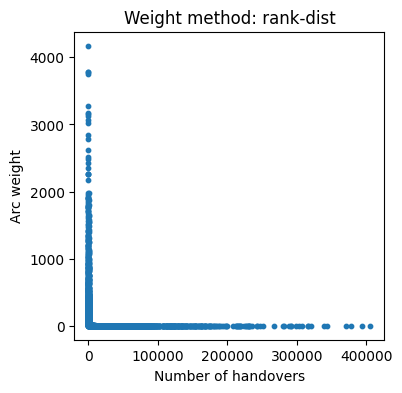

In [14]:
ho_df_day = compute_weight(ho_df_day, METHOD, absolute=ABS, enb_df=enb_df_day)

plt.figure(figsize=(4,4))
plt.title('Weight method: '+METHOD)
plt.scatter(ho_df_day.nbHO15, ho_df_day.Weight, s=10)
plt.xlabel('Number of handovers')
plt.ylabel('Arc weight')

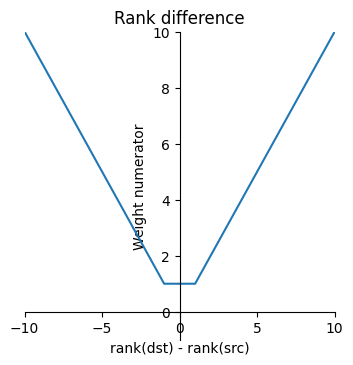

In [15]:
rank_diff = np.arange(-10, 11, 1)
r_src = 0
num = [max(1, abs(r_src-r_dst)) for r_dst in rank_diff]

fig, ax = plt.subplots(figsize=(4,4))
ax.set_title('Rank difference')
ax.plot(rank_diff, num)
ax.set_xlabel('rank(dst) - rank(src)')
ax.set_ylabel('Weight numerator')
ax.set_xlim(-10,10)
ax.set_ylim(-1,10)
ax.spines[["left", "bottom"]].set_position(("data", 0))
ax.spines[["top", "right"]].set_visible(False)


## 3. NetworkX graphs

In [16]:
TOTAL_HO_DAY = int(ho_df_day['nbHO15'].sum())
TOTAL_HO_DAY

78189320

In [17]:
G = nx.from_pandas_edgelist(ho_df_day, source='srcLocInfo', target='dstLocInfo', edge_attr='Weight', create_using=nx.DiGraph)

shortest_paths = []

for i in range(NB_PATHS):
    sp = nx.shortest_path(G, ENB_SRC, ENB_DST, weight='Weight', method='bellman-ford') # Bellman-Ford is better for directed graphs
    shortest_paths.append(sp)
    path_ho = compute_path_ho(ho_df_day, sp)
    traffic = np.round(path_ho/TOTAL_HO_DAY*100,1)
    print('Path length:', len(sp), '\tNumber of handovers:', path_ho, '('+str(traffic)+'%)')
    
    G = update_graph(G, sp, method='half')

Path length: 25 	Number of handovers: 3211180 (4.1%)
Path length: 19 	Number of handovers: 2231356 (2.9%)
Path length: 21 	Number of handovers: 2029048 (2.6%)


## 4. Folium visualization

In [18]:
lyon = create_map()
add_voronoi(lyon, enb_df_day)

colors = ['red', 'purple', 'blue']
for i,path in enumerate(shortest_paths):
    add_path(lyon, ho_df_day, path_list=path, name='Path '+str(i), color=colors[i], voronoi=True, enb_data=enb_df_day)
close_map(lyon, 'lyon_shortest_paths_daytime.html')
lyon

Creating base station map...
Adding Voronoi layer
Adding Path layer Path 0
Adding Path layer Path 1
Adding Path layer Path 2
Closing lyon_shortest_paths_daytime.html map.


# NIGHTTIME ANALYSIS
## 1. Import data

### Handover and EnB data

In [19]:
agg_df_night = pd.read_parquet('..\\Processed_data\\HO_AGG_16-22_NIGHTTIME_4G_coords_reduced.snappy.parquet', engine='fastparquet')
ho_df_night = agg_df_night.loc[agg_df_night.srcLocInfo != agg_df_night.dstLocInfo]
ho_df_night

,srcLocInfo,dstLocInfo,nbHO15,srcTechno,srcLON,srcLAT,dstTechno,dstLON,dstLAT
index,,,,,,,,,
144,8102f8100000994e,8102f81000009973,32,4G,4.818062,45.762236,4G,4.822226,45.763890
145,8102f8100000994e,8102f8100000998e,49,4G,4.818062,45.762236,4G,4.826943,45.729725
146,8102f8100000994e,8102f810000099a3,19,4G,4.818062,45.762236,4G,4.845132,45.747557
147,8102f8100000994e,8102f810000099b7,39,4G,4.818062,45.762236,4G,4.832777,45.772496
162,8102f81000009952,8102f81000009963,1785,4G,4.827545,45.752980,4G,4.830520,45.753373
...,...,...,...,...,...,...,...,...,...
5064,8102f8100000bacf,8102f8100000babc,11957,4G,4.867326,45.766061,4G,4.879249,45.766916
5066,8102f8100000bad0,8102f8100000997a,15,4G,4.820179,45.775520,4G,4.802506,45.767224
5067,8102f8100000bad0,8102f810000099c6,1173,4G,4.820179,45.775520,4G,4.829172,45.776392


In [20]:
PATH_TOPO = '..\\..\\Data_Handover\\TOPO\\Lyon\\part-00000-2f038a97-7faf-46f3-aee2-b73b52bf2cba.snappy.parquet'
enb_df_night = pd.read_parquet(PATH_TOPO, engine='fastparquet')
enb_df_night = enb_df_night.loc[enb_df_night['LocInfo'].isin(ho_df_night['srcLocInfo'])].reset_index(drop=True)
enb_df_night

,LocInfo,TECHNO,LON,LAT
0,8102f8100000999d,4G,4.888138,45.738378
1,8102f81000009b28,4G,4.819723,45.771390
2,8102f8100000997e,4G,4.875561,45.753615
3,8102f81000009976,4G,4.846672,45.729169
4,8102f81000009959,4G,4.822966,45.733027
...,...,...,...,...
179,8102f81000009f4a,4G,4.874679,45.764310
180,8102f8100000997b,4G,4.880686,45.725675
181,8102f8100000ba70,4G,4.867783,45.701943
182,8102f8100000996d,4G,4.864943,45.729614


## 2. Assign node and flow attributes

### Nodes: geographic ranking

In [21]:
enb_df_night = assign_georank(enb_df_night, src_id=ENB_SRC)
enb_df_night

,LocInfo,TECHNO,LON,LAT,Georank
0,8102f8100000999d,4G,4.888138,45.738378,82
1,8102f81000009b28,4G,4.819723,45.771390,37
2,8102f8100000997e,4G,4.875561,45.753615,72
3,8102f81000009976,4G,4.846672,45.729169,42
4,8102f81000009959,4G,4.822966,45.733027,18
...,...,...,...,...,...
179,8102f81000009f4a,4G,4.874679,45.764310,74
180,8102f8100000997b,4G,4.880686,45.725675,76
181,8102f8100000ba70,4G,4.867783,45.701943,71
182,8102f8100000996d,4G,4.864943,45.729614,60


### Flows: handover weight

Text(0, 0.5, 'Arc weight')

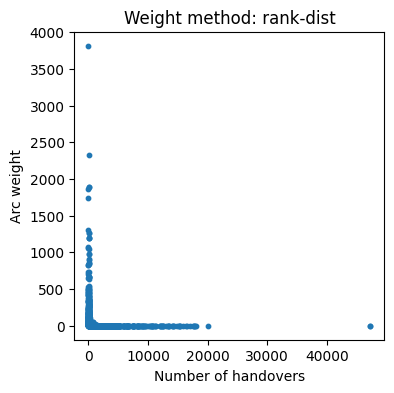

In [22]:
ho_df_night = compute_weight(ho_df_night, METHOD, absolute=ABS, enb_df=enb_df_night)

plt.figure(figsize=(4,4))
plt.title('Weight method: '+METHOD)
plt.scatter(ho_df_night.nbHO15, ho_df_night.Weight, s=10)
plt.xlabel('Number of handovers')
plt.ylabel('Arc weight')

## 3. NetworkX graphs

In [23]:
TOTAL_HO_NIGHT = int(ho_df_night['nbHO15'].sum())
TOTAL_HO_NIGHT

2315427

In [24]:
G = nx.from_pandas_edgelist(ho_df_night, source='srcLocInfo', target='dstLocInfo', edge_attr='Weight', create_using=nx.DiGraph)

shortest_paths = []

for i in range(NB_PATHS):
    sp = nx.shortest_path(G, ENB_SRC, ENB_DST, weight='Weight', method='bellman-ford') # Bellman-Ford is better for directed graphs
    shortest_paths.append(sp)
    path_ho = compute_path_ho(ho_df_night, sp)
    traffic = np.round(path_ho/TOTAL_HO_NIGHT*100,1)
    print('Path length:', len(sp), '\tNumber of handovers:', path_ho, '('+str(traffic)+'%)')
    
    G = update_graph(G, sp, method='half')

Path length: 21 	Number of handovers: 76232 (3.3%)
Path length: 20 	Number of handovers: 90438 (3.9%)
Path length: 23 	Number of handovers: 109779 (4.7%)


## 4. Folium visualization

In [25]:
lyon = create_map()
add_voronoi(lyon, enb_df_night)

colors = ['red', 'purple', 'blue']
for i,path in enumerate(shortest_paths):
    add_path(lyon, ho_df_night, path_list=path, name='Path '+str(i), color=colors[i], voronoi=True, enb_data=enb_df_night)
close_map(lyon, 'lyon_shortest_paths_nighttime.html')
lyon

Creating base station map...
Adding Voronoi layer
Adding Path layer Path 0
Adding Path layer Path 1
Adding Path layer Path 2
Closing lyon_shortest_paths_nighttime.html map.


(-10000.0, 400000.0)

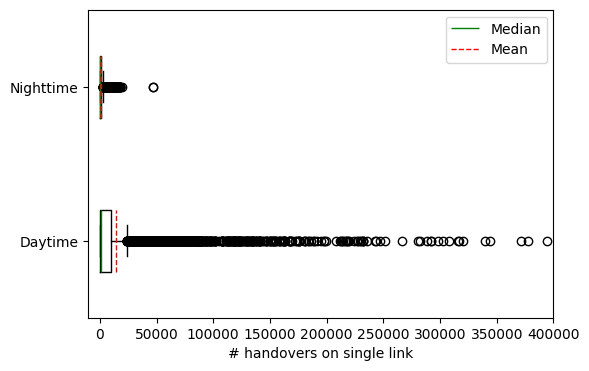

In [26]:
# Distribution of handovers
fig,ax = plt.subplots(figsize=(6,4))
bp = ax.boxplot([agg_df_day.nbHO15, agg_df_night.nbHO15], 
            vert=False, 
            widths=0.4,
            meanline=True, 
            showmeans=True, 
            medianprops={'color':'green','ls':'-'},
            meanprops={'color':'red','ls':'--'}
            )

ax.legend([bp['medians'][0], bp['means'][0]], ['Median', 'Mean'], loc='upper right')
ax.set_yticklabels(['Daytime','Nighttime'])
ax.set_xlabel('# handovers on single link')
ax.set_xlim(-10000, 400000)

(-1000.0, 30000.0)

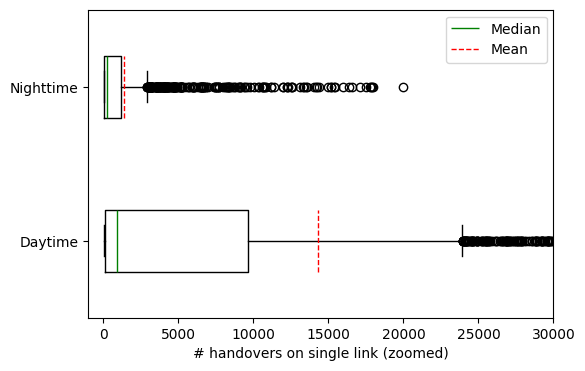

In [27]:
# Distribution of handovers (zoomed)
fig,ax = plt.subplots(figsize=(6,4))
bp = ax.boxplot([agg_df_day.nbHO15, agg_df_night.nbHO15], 
            vert=False, 
            widths=0.4,
            meanline=True, 
            showmeans=True, 
            medianprops={'color':'green','ls':'-'},
            meanprops={'color':'red','ls':'--'}
            )

ax.legend([bp['medians'][0], bp['means'][0]], ['Median', 'Mean'], loc='upper right')
ax.set_yticklabels(['Daytime','Nighttime'])
ax.set_xlabel('# handovers on single link (zoomed)')
ax.set_xlim(-1000, 30000)

# GROUND-TRUTH DATA

## 1. Angelo data

In [32]:
PATH_GT = '..\\..\\Data_Handover\\GroundTruth\\GROUNDTRUTH_'

path_bike = [pd.read_parquet(PATH_GT + 'BICYCLE.snappy.parquet', engine='fastparquet')]
path_car = [pd.read_parquet(PATH_GT + 'CAR_'+str(i)+'.snappy.parquet', engine='fastparquet') for i in range(1,3)] # Useful paths: 1 and 2
path_tcl = [pd.read_parquet(PATH_GT + 'TCL_'+str(i)+'.snappy.parquet', engine='fastparquet') for i in range(1,3)] # Useful paths: 1 and 2

In [77]:
lyon = create_map()
#add_voronoi(lyon, enb_df_night)

paths = path_tcl
colors = ['red', 'purple', 'blue']
for i,path in enumerate(paths):
    add_gt_path(lyon, path, name='TCL path '+str(i), color=colors[i])
close_map(lyon, 'lyon_gtpaths_TCL.html')
lyon

Creating base station map...
Adding Path layer TCL path 0
Adding Path layer TCL path 1
Adding Path layer TCL path 2
Closing lyon_gtpaths_TCL.html map.


In [52]:
def find_closest_enb(path, enb_df):
    enb_path = []
    enb_list, enb_coords = enb_df.LocInfo.tolist(), list(zip(enb_df.LON.tolist(), enb_df.LAT.tolist()))
    enb_dict = dict(zip(enb_list, enb_coords))
    for idx,row in path.iterrows():
        point = [row.LON, row.LAT]
        distances = {enb: dist(point, enb_dict[enb]) for enb in enb_list}
        closest_enb = min(distances, key=distances.get)
        enb_path.append(closest_enb)
    return list(dict.fromkeys(enb_path)) # remove duplicates while preserving order

In [53]:
path = path_bike[0]
find_closest_enb(path, enb_df_day)

['8102f8100000ba53',
 '8102f8100000a1ae',
 '8102f8100000ba4e',
 '8102f81000009959',
 '8102f81000009979',
 '8102f8100000ad6c',
 '8102f81000009975',
 '8102f8100000a4bb',
 '8102f8100000998f',
 '8102f81000009972',
 '8102f8100000996c',
 '8102f810000099aa',
 '8102f8100000a0bc',
 '8102f8100000a670']

In [40]:
l = list(zip(enb_df_day.LON.tolist(), enb_df_day.LAT.tolist()))
l[0][0]

4.888138